In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [19]:
# data preprocessing
data = pd.read_csv('data/accident_whether.csv')

# extract the data, column STATE , STATENAME, LGT_CONDNAME, WEATHER1NAME, fatal
data = data[['STATE', 'STATENAME', 'LGT_CONDNAME', 'WEATHER1NAME', 'FATALS']]
print(data.head())

   STATE STATENAME        LGT_CONDNAME WEATHER1NAME  FATALS
0      1   Alabama                Dawn        Clear       1
1      1   Alabama  Dark - Not Lighted         Rain       2
2      1   Alabama  Dark - Not Lighted       Cloudy       1
3      1   Alabama            Daylight       Cloudy       1
4      1   Alabama            Daylight        Clear       1


In [20]:
# handel the missing data， drop the missing data
data = data.dropna()

features = data[['LGT_CONDNAME', 'WEATHER1NAME']]

# filter the feature data such as other and unknown
unwanted_conditions = ['Other', 'Reported as Unknown', 'Not Reported']
features = features[~features['LGT_CONDNAME'].isin(unwanted_conditions)]
features = features[~features['WEATHER1NAME'].isin(unwanted_conditions)]
features = features.dropna()

# one hot encoding, there is one code to match the combination of the two features
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(features)

# 打印独热编码后的特征矩阵形状
print("the shape after oneHot-encode:", encoded_features.shape)

# 打印独热编码后的特征对应的列名
feature_names = encoder.get_feature_names_out(['LGT_CONDNAME', 'WEATHER1NAME'])
print("独热编码后的特征对应的列名：")
# print(feature_names)

# normalize the data, 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)
print(scaled_features)

# 打印标准化后的特征矩阵形状
print("标准化后的特征矩阵形状：", scaled_features.shape)

the shape after oneHot-encode: (31183, 16)
独热编码后的特征对应的列名：
[[-0.50742531 -0.61943296 -0.07683245 ... -0.03885237 -0.04709194
  -0.10928054]
 [-0.50742531  1.6143797  -0.07683245 ... -0.03885237 -0.04709194
  -0.10928054]
 [-0.50742531  1.6143797  -0.07683245 ... -0.03885237 -0.04709194
  -0.10928054]
 ...
 [-0.50742531  1.6143797  -0.07683245 ... -0.03885237 -0.04709194
  -0.10928054]
 [-0.50742531 -0.61943296 -0.07683245 ... -0.03885237 -0.04709194
  -0.10928054]
 [-0.50742531 -0.61943296 -0.07683245 ... -0.03885237 -0.04709194
  -0.10928054]]
标准化后的特征矩阵形状： (31183, 16)


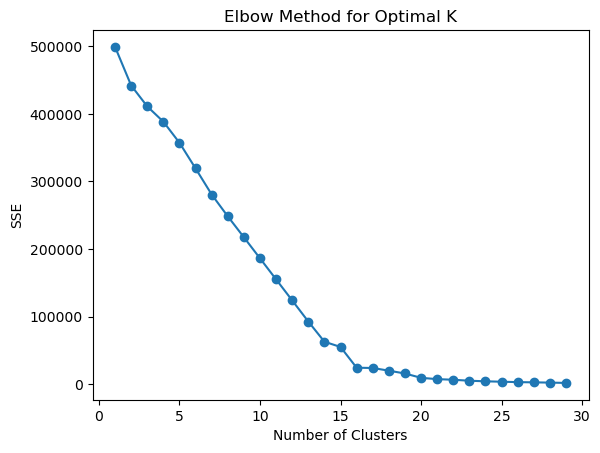

In [21]:
# to find the best k value
k_values = range(1, 30)
sse = []     # 用于保存轮廓系数
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

# plot the sse
plt.plot(range(1, 30), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()


In [22]:

# 根据肘部法选择合适的K值（例如，K=3）
optimal_k = 17
kmeans = KMeans(n_clusters=optimal_k, random_state=2)
clusters = kmeans.fit_predict(scaled_features)

# 将聚类结果添加到原始数据中
print(len(clusters))
print(len(data))

data_filtered = data.loc[features.index]  # 只选择过滤后的数据行
data_filtered['Cluster'] = clusters

# 输出结果
print(data_filtered[['LGT_CONDNAME', 'WEATHER1NAME', 'Cluster']].head())


31183
33919
         LGT_CONDNAME WEATHER1NAME  Cluster
0                Dawn        Clear        2
1  Dark - Not Lighted         Rain        3
2  Dark - Not Lighted       Cloudy        1
3            Daylight       Cloudy       14
4            Daylight        Clear        0


In [24]:
# 统计每个簇的特征组合
feature_combinations = data_filtered.groupby(['Cluster', 'LGT_CONDNAME', 'WEATHER1NAME']).size().reset_index(name='Count')

# 输出结果
print("\n每个簇的特征组合：")
print(feature_combinations)

# 计算总体特征组合的频率
total_combinations = data_filtered.groupby(['LGT_CONDNAME', 'WEATHER1NAME']).size().reset_index(name='TotalCount')

# 输出结果
print("\n总体特征组合的频率：")
print(total_combinations)

# 计算总体特征组合的频率
total_combinations = data_filtered.groupby(['LGT_CONDNAME', 'WEATHER1NAME']).size().reset_index(name='TotalCount')

# 输出结果
print("\n总体特征组合的频率：")
print(total_combinations)


每个簇的特征组合：
    Cluster             LGT_CONDNAME              WEATHER1NAME  Count
0         0                 Daylight                     Clear  10641
1         1       Dark - Not Lighted                    Cloudy   1466
2         2                     Dawn                     Clear    407
3         2                     Dawn                    Cloudy    119
4         2                     Dawn                      Rain     58
5         3           Dark - Lighted                      Rain    639
6         3       Dark - Not Lighted                      Rain    767
7         3                 Daylight                      Rain   1135
8         4       Dark - Not Lighted                     Clear   6044
9         5  Dark - Unknown Lighting                     Clear    144
10        5  Dark - Unknown Lighting                    Cloudy     14
11        5  Dark - Unknown Lighting          Fog, Smog, Smoke      1
12        5  Dark - Unknown Lighting                      Rain     21
13       

In [25]:
# 计算每个簇的数据数目
cluster_counts = data_filtered['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print("每个簇的数据数目：") 
print(cluster_counts)

# 查看每个簇的实际文本特征
for cluster in cluster_counts['Cluster']:
    cluster_data = data_filtered[data_filtered['Cluster'] == cluster]
    print(f"\nCluster {cluster} 特征分布：")
    print(cluster_data['LGT_CONDNAME'].value_counts())
    print(cluster_data['WEATHER1NAME'].value_counts())

每个簇的数据数目：
    Cluster  Count
0         0  10641
1         4   6044
2         6   4769
3        14   3328
4         3   2541
5         1   1466
6         8    725
7         2    584
8        13    359
9        16    356
10        5    183
11       12     69
12        7     47
13       10     31
14       11     21
15        9     10
16       15      9

Cluster 0 特征分布：
Daylight    10641
Name: LGT_CONDNAME, dtype: int64
Clear    10641
Name: WEATHER1NAME, dtype: int64

Cluster 4 特征分布：
Dark - Not Lighted    6044
Name: LGT_CONDNAME, dtype: int64
Clear    6044
Name: WEATHER1NAME, dtype: int64

Cluster 6 特征分布：
Dark - Lighted    4769
Name: LGT_CONDNAME, dtype: int64
Clear    4769
Name: WEATHER1NAME, dtype: int64

Cluster 14 特征分布：
Daylight          2481
Dark - Lighted     847
Name: LGT_CONDNAME, dtype: int64
Cloudy    3328
Name: WEATHER1NAME, dtype: int64

Cluster 3 特征分布：
Daylight              1135
Dark - Not Lighted     767
Dark - Lighted         639
Name: LGT_CONDNAME, dtype: int64
Rain    2541

过滤后的数据大小： (8383, 2)
独热编码后的特征矩阵形状： (8383, 16)
独热编码后的特征对应的列名：
['LGT_CONDNAME_Dark - Lighted' 'LGT_CONDNAME_Dark - Not Lighted'
 'LGT_CONDNAME_Dark - Unknown Lighting' 'LGT_CONDNAME_Dawn'
 'LGT_CONDNAME_Daylight' 'LGT_CONDNAME_Dusk'
 'WEATHER1NAME_Blowing Sand, Soil, Dirt' 'WEATHER1NAME_Blowing Snow'
 'WEATHER1NAME_Clear' 'WEATHER1NAME_Cloudy'
 'WEATHER1NAME_Fog, Smog, Smoke' 'WEATHER1NAME_Freezing Rain or Drizzle'
 'WEATHER1NAME_Rain' 'WEATHER1NAME_Severe Crosswinds'
 'WEATHER1NAME_Sleet or Hail' 'WEATHER1NAME_Snow']
标准化后的特征矩阵形状: (8383, 16)
标准化后的特征矩阵前5行: [[-0.63797788  2.62273891 -0.07263892 -0.1358925  -1.06983094 -0.16569353
  -0.01892076 -0.0109226  -1.78413389 -0.42274346 -0.09628295 -0.01892076
   3.65774162 -0.02890884 -0.03455886 -0.07667809]
 [ 1.56745246 -0.3812808  -0.07263892 -0.1358925  -1.06983094 -0.16569353
  -0.01892076 -0.0109226  -1.78413389  2.3655008  -0.09628295 -0.01892076
  -0.27339274 -0.02890884 -0.03455886 -0.07667809]
 [ 1.56745246 -0.3812808  -0.07263892 -0.13

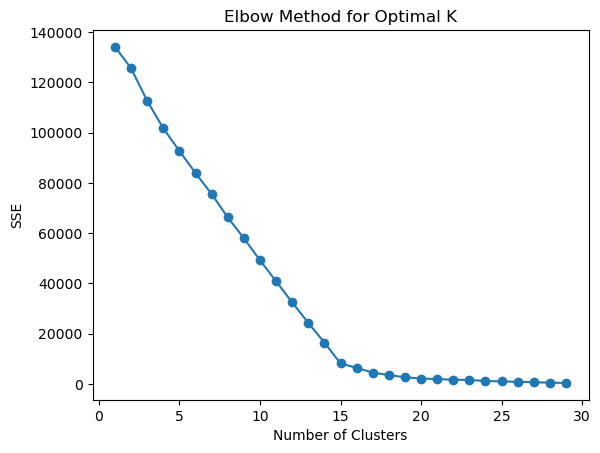

          LGT_CONDNAME WEATHER1NAME  Cluster
1   Dark - Not Lighted         Rain        2
8       Dark - Lighted       Cloudy        0
12      Dark - Lighted        Clear        0
17                Dusk        Clear        2
19            Daylight        Clear        2


In [27]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取数据
try:
    data = pd.read_csv('data/accident_whether.csv')
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()

# 处理缺失值
data = data.dropna()

# 选择天气和光线条件特征
features = data[['LGT_CONDNAME', 'WEATHER1NAME']]

# 过滤掉不需要的特征值
unwanted_conditions = ['Other', 'Reported as Unknown', 'Not Reported']
features = features[~features['LGT_CONDNAME'].isin(unwanted_conditions)]
features = features[~features['WEATHER1NAME'].isin(unwanted_conditions)]
features = features.dropna()

# 打印过滤后的数据大小
print("过滤后的数据大小：", features.shape)

# 独热编码
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(features)

# 打印独热编码后的特征矩阵形状
print("独热编码后的特征矩阵形状：", encoded_features.shape)

# 打印独热编码后的特征对应的列名
feature_names = encoder.get_feature_names_out(['LGT_CONDNAME', 'WEATHER1NAME'])
print("独热编码后的特征对应的列名：")
print(feature_names)

# 标准化数据
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_features)

# 打印标准化后的特征矩阵形状
print("标准化后的特征矩阵形状:", scaled_features.shape)

# 检查标准化后的数据
print("标准化后的特征矩阵前5行:", scaled_features[:5])

# 使用肘部法确定最佳K值
sse = []
k_values = range(1, 30)
for k in k_values:
    try:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    except Exception as e:
        print(f"Error fitting KMeans for k={k}: {e}")
        exit()

# 绘制肘部法图形
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()

# 根据肘部法选择合适的K值（例如，K=3）
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# 将聚类结果添加到原始数据中
data_filtered = data.loc[features.index]  # 只选择过滤后的数据行
data_filtered['Cluster'] = clusters

# 输出结果
print(data_filtered[['LGT_CONDNAME', 'WEATHER1NAME', 'Cluster']].head())

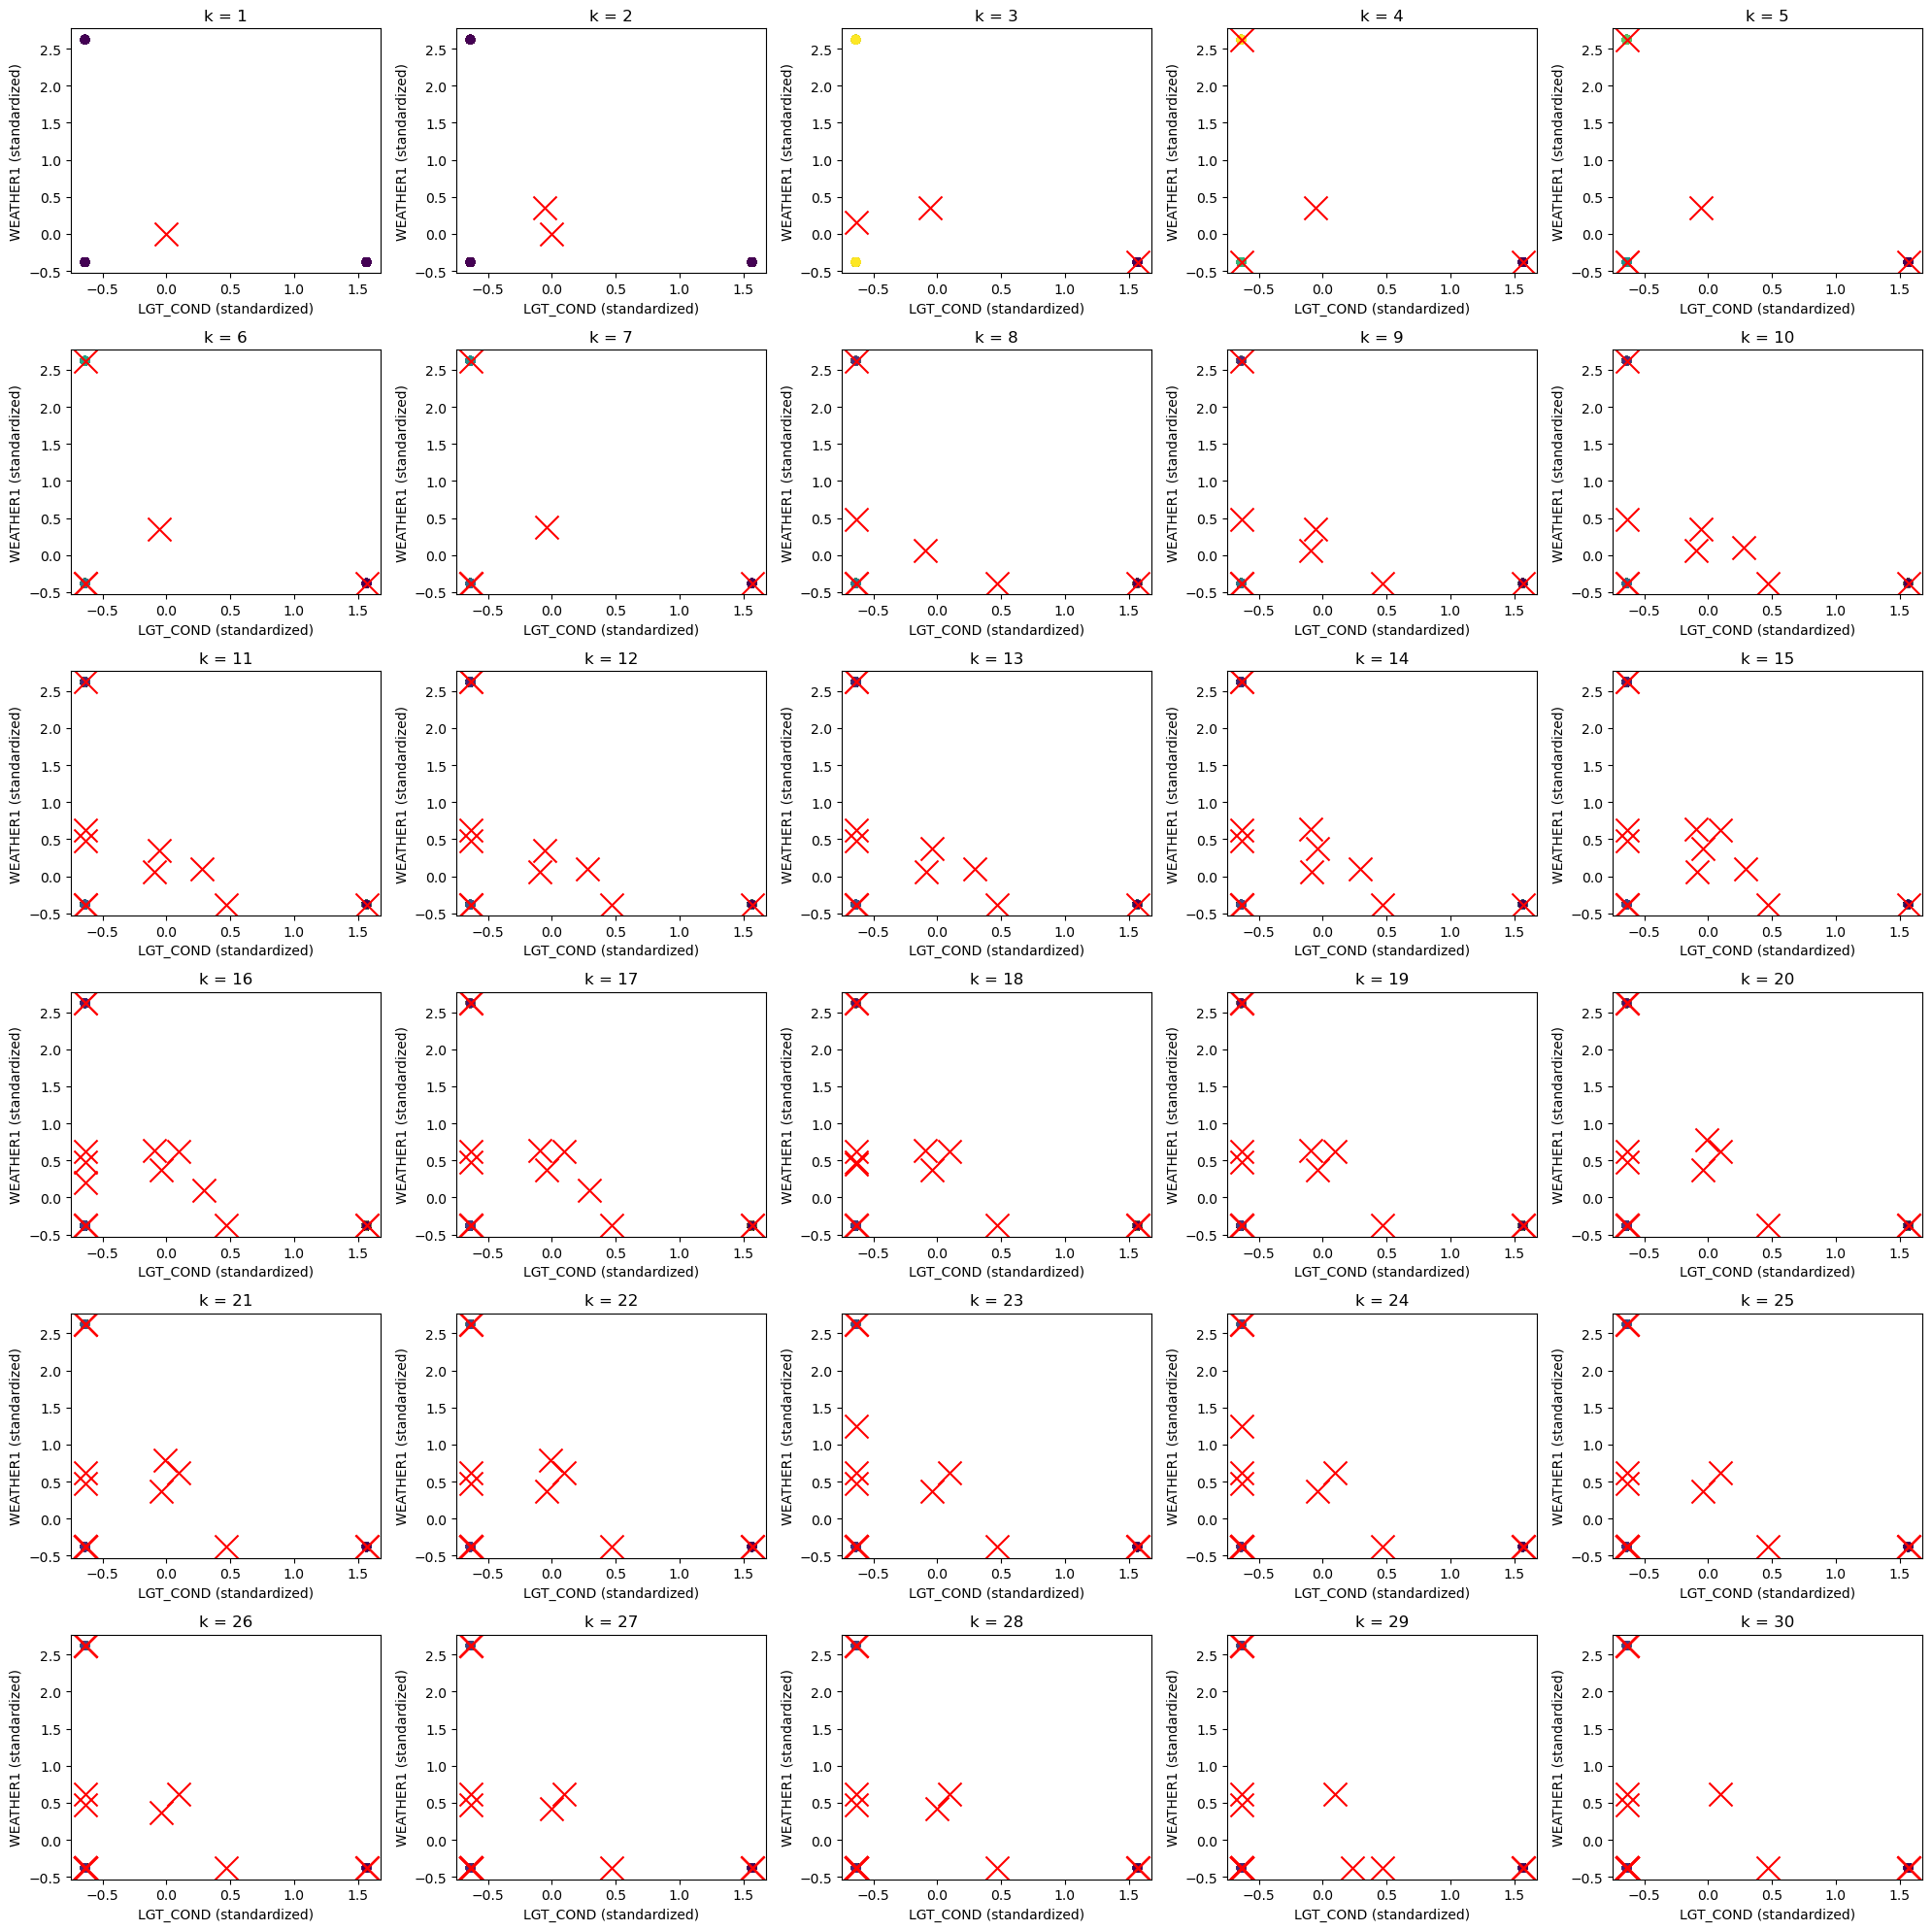

In [28]:
# 定义要尝试的聚类数目
k_values = list(range(1, 31))

# 设置网格大小
rows = 6
cols = 5

# 创建一个绘图网格
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

for idx, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    # 绘制聚类结果
    axes[idx].scatter(scaled_features[:, 0], scaled_features[:, 1], c=clusters, cmap='viridis', marker='o')
    axes[idx].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
    axes[idx].set_title(f'k = {k}')
    axes[idx].set_xlabel('LGT_COND (standardized)')
    axes[idx].set_ylabel('WEATHER1 (standardized)')

# 隐藏多余的子图
for idx in range(len(k_values), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()